In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from typing import List, Optional, Tuple, Union

from pandas.core.frame import DataFrame
from pandas.core.series import Series

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '/Users/f.b/Desktop/Data_Science/Clock_industry/scripts/cleaning_analysis/propre/propre.csv'
df = pd.read_csv(path)
df = df.iloc[:, 1:]
df = df.drop(columns=['annee_prod'])

In [3]:
df.isnull().sum()

marque                   0
modele                   0
mouvement               88
matiere_boitier        292
matiere_bracelet      1822
etat                     0
sexe                   220
prix                   898
reserve_de_marche     2818
diametre               261
etencheite            2833
matiere_lunette       1103
matiere_verre         1216
boucle                 852
matiere_boucle         699
comptage_fonctions       0
pays                     0
dtype: int64

In [4]:
df.dtypes

marque                 object
modele                 object
mouvement              object
matiere_boitier        object
matiere_bracelet       object
etat                   object
sexe                   object
prix                  float64
reserve_de_marche     float64
diametre              float64
etencheite            float64
matiere_lunette        object
matiere_verre          object
boucle                 object
matiere_boucle         object
comptage_fonctions      int64
pays                   object
dtype: object

In [5]:
df.shape

(22960, 17)

In [6]:
df['prix_log'] = np.log(df['prix'])

In [7]:
# Remplacer les valeurs manquantes par la médiane pour toutes les colonnes numériques
df.fillna(df.select_dtypes(include='float64').median(), inplace=True)

# Remplacer les valeurs manquantes par la modalité la plus fréquente pour toutes les colonnes catégorielles
df.fillna(df.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [8]:
def get_categorical_vars(df, n_levels_max):
    categorical_vars = [
        col for col in df.columns
        if df[col].dtypes == "object" and len(df[col].unique()) < n_levels_max
    ]
    return categorical_vars

In [9]:
categorical_vars = get_categorical_vars(df,30)

In [10]:
def get_most_frequent_levels(df, categorical_vars):
    most_frequent = {}
    for var in categorical_vars:
        most_frequent[var] = df[var].value_counts().index[0]
    return  most_frequent


In [11]:
most_frequent = get_most_frequent_levels(df, categorical_vars)

In [12]:
df = pd.get_dummies(
    df,
    dummy_na=True, 
    drop_first=False
    
)

In [13]:
df = df.astype(int)

In [14]:
# Supprimer les colonnes se terminant par '_nan'
df = df[df.columns[~df.columns.str.endswith('_nan')]]

In [15]:
def remove_reference_levels(df, reference_levels):
    removed = []
    for var, lvl in reference_levels.items():
        var_name = f"{var}_{lvl}"
        
        if var_name in df.columns:
            df = df.drop([var_name], axis = 1)
            removed.append(var_name)
    return df, removed

In [16]:
df, remove = remove_reference_levels(df, most_frequent)

In [17]:
X = df.drop(['prix_log','prix'], axis=1)  # Remplacez 'target_column' par le nom de votre colonne cible
y = df['prix_log']  # Votre colonne cible

# Découpage en données d'apprentissage (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(f"{X_train.shape[0]:,} exemples d'entrainement pour {X_train.shape[1]} features.")
print(f"{X_test.shape[0]:,} exemples test.")

18,368 exemples d'entrainement pour 1417 features.
4,592 exemples test.


In [19]:
features = list(X_train.columns)

In [20]:
from typing import (
    Optional, 
    Dict, 
    List,
    Union
)

def compute_mutual_info(X: np.ndarray, y: np.ndarray, feature_names: List, n_neighbors: int=10) -> pd.Series: 
    """Description. Compute mutual information for each feature.
    
    Args:
        X (np.ndarray): Feature vector.
        y (np.ndarray): Target vector.
        feature_names (List): List of feature names.
        n_neighbors (int): Number of neighbors to use for MI estimation.
        
    Returns:
        pd.Series: Mutual information for each feature sorted in descending order."""

    mi = mutual_info_regression(
        X, 
        y, 
        discrete_features="auto", 
        n_neighbors=n_neighbors, 
        copy=True) 

    mi = pd.Series(mi, index=feature_names).sort_values(ascending=False)
    return mi

def compute_rf_importances(
        X: np.ndarray, 
        y: np.ndarray, 
        feature_names: List, 
        rf: Optional[RandomForestRegressor]=None, 
        kwargs: Optional[Dict]=None
    ) -> pd.Series: 
    """Description. Compute mean decrease Ginin for each feature from random forest.
    
    Args:
        X (np.ndarray): Feature vector.
        y (np.ndarray): Target vector.
        feature_names (List): List of feature names.
        kwargs (Optional[Dict]): arguments to pass to RandomForestRegressor.
        
    Returns:
        pd.Series: Random forest importances for each feature sorted in descending order."""

    if rf == None: 

        if kwargs == None:
            rf = RandomForestRegressor()
        else:
            rf = RandomForestRegressor(**kwargs)
        rf.fit(X, y)
        print("RandomForestRegressor fitted.")

        mape = 100 * mean_absolute_percentage_error(y, rf.predict(X))
        print(f"Train MAPE: {round(mape, 2)}%")

    importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
    return importances

def select_important_features(importances: pd.Series, threshold: Union[str, float] = "mean") -> List[str]:
    """
    Sélectionne les features dont l'importance est supérieure à un seuil donné.

    Args:
        importances (pd.Series): Série contenant les importances des features.
        threshold (Union[str, float]): Seuil pour la sélection des features.
                                       Peut être 'mean', '25%', '50%', '75%', '90%', '95%', '99%', ou un float.

    Returns:
        List[str]: Liste des features sélectionnées.
    """
    # Vérifier que importances est bien une pd.Series
    if not isinstance(importances, pd.Series):
        raise TypeError("Les importances doivent être une pd.Series.")
    
    # Calcul du seuil basé sur les différentes options
    if threshold == "mean":
        threshold = importances.mean()
    elif threshold in ["25%", "50%", "75%", "90%", "95%", "99%"]:
        quantile = float(threshold.strip('%')) / 100
        threshold = importances.quantile(quantile)
    elif isinstance(threshold, float):
        # Si le seuil est un float explicite
        pass
    else:
        raise ValueError(f"{threshold} n'est pas une méthode de seuil valide.")
    
    # Sélectionner les features avec une importance supérieure au seuil
    selected_features = importances[importances > threshold].index.tolist()
    
    return selected_features

In [21]:
if len(X_train) <= 150000:     
    # compute mutual information between features and target
    # if dataset is small enough
    mi_values = compute_mutual_info(X_train, y_train, features)

In [22]:
mdg_values = compute_rf_importances(X_train, y_train, features)

RandomForestRegressor fitted.
Train MAPE: 1.89%


In [27]:
mi_threshold = "99%"
mdg_threshold = "99%"

important_features_mi = select_important_features(mi_values, threshold=mi_threshold)
important_features_mdg = select_important_features(mdg_values, threshold=mdg_threshold)

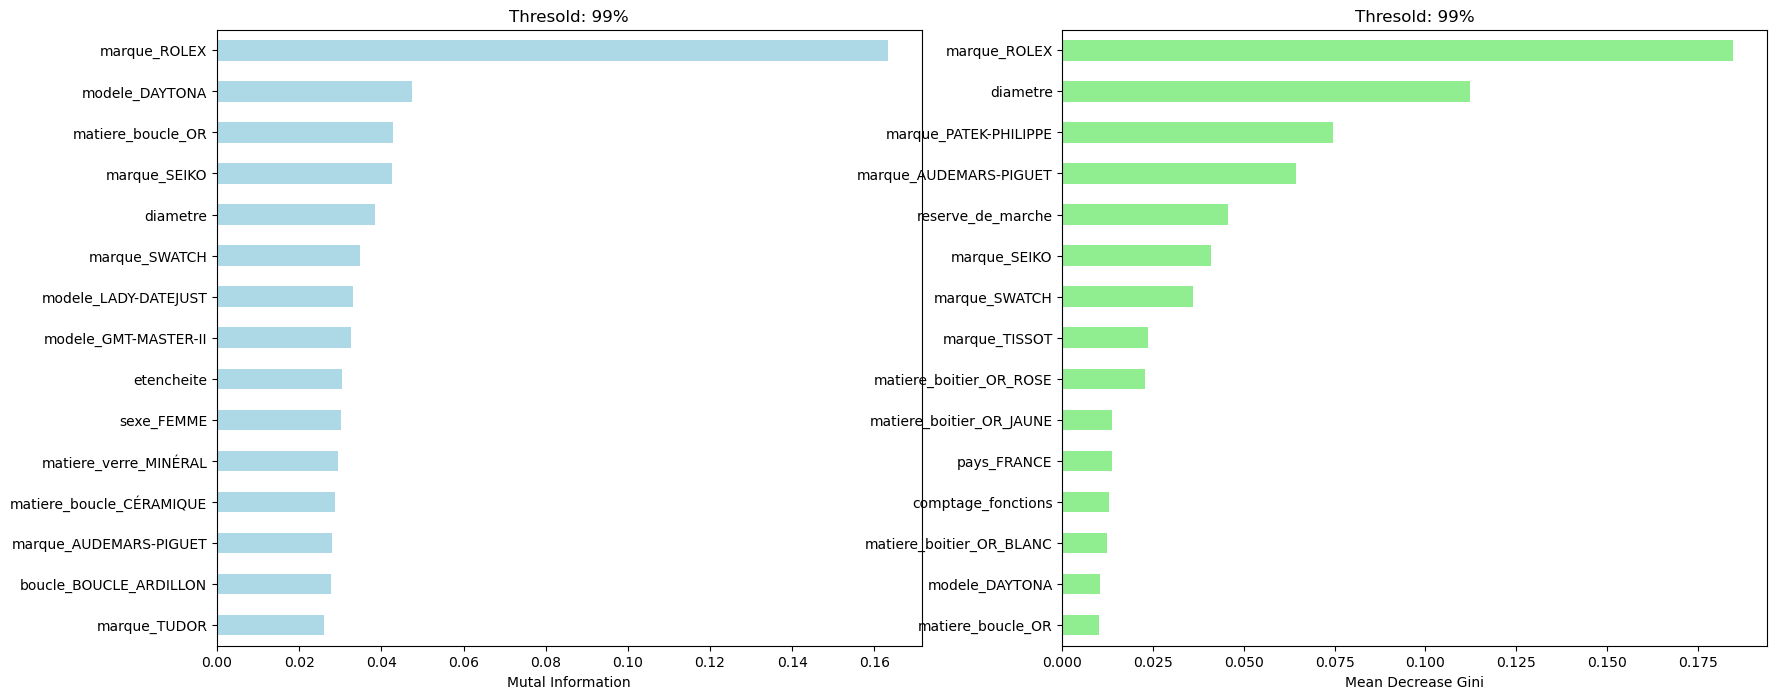

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))

mi_values[important_features_mi]\
    .sort_values()\
    .plot.barh(ax=axes[0], color="lightblue")

axes[0].set_xlabel("Mutal Information")
axes[0].set_title(f"Thresold: {mi_threshold}")

mdg_values[important_features_mdg]\
    .sort_values()\
    .plot.barh(ax=axes[1], color="lightgreen")

axes[1].set_xlabel("Mean Decrease Gini")
axes[1].set_title(f"Thresold: {mdg_threshold}"); 